In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import math
from scipy.stats import norm
from scipy.optimize import minimize

### Problem 1
Consider BSM Put: $P = Ke^{-rT}N(-Z_{-}) - Se^{-yT}N(-Z_{+})\\ $
(a)
$$\Delta_S = \frac{\partial P}{\partial S} = -e^{-yt}N(-Z_{+})\\
\Delta_K = \frac{\partial P}{\partial K} = e^{-rT}N(-Z_{-})\\
\Gamma_{SS} = \frac{\partial^2 P}{\partial S^2} = -e^{-yt} \partial_S N(-Z_{+}) = \frac{-e^{-yT}}{\sigma\sqrt{T}S}n(-Z_{+}) \\
\Gamma_{SK} = \frac{\partial^2 P}{\partial S \partial K} = -e^{-yt} \partial_K N(-Z_{+}) = \frac{e^{-yT}}{\sigma\sqrt{T}K}n(-Z_{+}) \\
\Gamma_{KS} = \frac{\partial^2 P}{\partial K \partial S} = e^{-rt} \partial_S N(-Z_{-}) = \frac{e^{-rT}}{\sigma\sqrt{T}S}n(-Z_{-}) \\
\Gamma_{KK} = \frac{\partial^2 P}{\partial K^2} = e^{-rt} \partial_K N(-Z_{-}) = \frac{-e^{-rT}}{\sigma\sqrt{T}K}n(-Z_{-})  \\$$
(i) All asset prices are in numeraire units (dollars for instance), therefore deltas would be $\frac{measuringstick}{measuring stick}$ and gammas will be $\frac{measuring stick}{measuring stick^2}$

In [4]:
# (ii) Get the prices

# Set d1 and d2 (or z+ and z-)
def z_values(S, K, r, y, T, sigma):
    z_plus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) + (sigma * math.sqrt(T))/2
    z_minus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) - (sigma * math.sqrt(T))/2
    return z_plus, z_minus

# Define delta S
def delta_S(z_plus, y, T):
    return -math.exp(-y*T) * norm.cdf(-z_plus)

# Define delta K
def delta_K(z_minus, y, T):
    return math.exp(-r*T) * norm.cdf(-z_minus)

# Define gamma SS
def gamma_SS(z_plus, S, y, T, sigma):
    return (-math.exp(-y*T) * norm.cdf(-z_plus))/(sigma * np.sqrt(T) * S)

# Define gamma SK
def gamma_SK(z_plus, K, y, T, sigma):
    return (math.exp(-y*T) * norm.cdf(-z_plus))/(sigma * np.sqrt(T) * K)

# Define gamma KS
def gamma_KS(z_minus, K, r, T, sigma):
    return (math.exp(-r*T) * norm.cdf(-z_minus))/(sigma * np.sqrt(T) * S)

# Define gamma KK  
def gamma_KK(z_minus, K, r, T, sigma):
    return (-math.exp(-r*T) * norm.cdf(-z_minus))/(sigma * np.sqrt(T) * K)

# Set numerical values
S = 5000
K = [4500, 5000, 5500]
r = 0.049
y = 0.011
T = 1
sigma = 0.155

# Create a DataFrame to store results
results = pd.DataFrame(columns=['Strike Price', 'Delta S', 'Delta K', 'Gamma SS', 'Gamma SK', 'Gamma KS', 'Gamma KK'])
for strike in K:                                            # Iterate through strike prices
    z_plus, z_minus = z_values(S, strike, r, y, T, sigma)
    result = {
        'Strike Price': strike,
        'Delta S': delta_S(z_plus, y, T),
        'Delta K': delta_K(z_minus, y, T),
        'Gamma SS': gamma_SS(z_plus, S, y, T, sigma),
        'Gamma SK': gamma_SK(z_plus, strike, y, T, sigma),
        'Gamma KS': gamma_KS(z_minus, strike, r, T, sigma),
        'Gamma KK': gamma_KK(z_minus, strike, r, T, sigma)
    }
    results = results.append(result, ignore_index=True)     # Append values to the dataframe

results

AttributeError: 'DataFrame' object has no attribute 'append'

(iii) 
$$ S\Delta_S + K\Delta_K = -Se^{-yt}N(-Z_{+}) + Ke^{-rT}N(-Z_{-}) = P \\
S\Gamma_{SS} + K\Gamma_{SK} = S\frac{-e^{-yT}}{\sigma\sqrt{T}S}n(-Z_{+}) + K\frac{e^{-yT}}{\sigma\sqrt{T}K}n(-Z_{+}) = 0 \\
S\Gamma_{KS} + K\Gamma_{KK} = S\frac{e^{-rT}}{\sigma\sqrt{T}S}n(-Z_{-}) + K\frac{-e^{-rT}}{\sigma\sqrt{T}K}n(-Z_{-}) = 0
$$
We can write the composition of replicating portfolio with delta sums. Gamma sums being zero reflects dynamic hedging properties of the portfolio.

(b) (i)
$$\rho_r = \frac{\partial P}{\partial r} = -TKe^{-rT}N(-Z_{-})\\
\rho_y = \frac{\partial P}{\partial y} = TSe^{-yT}N(-Z_{+}) \\
\nu = \frac{\partial P}{\partial \sigma} = -\sqrt{T}Se^{-yT}n(-Z_{+}) = \sqrt{T}Ke^{-rT}n(-Z_{-})
$$
r and y have $time^{-1}$ units, while vega has $time^{1/2}$

In [ ]:
# Define rho r
def rho_r(z_minus, K, r, T):
    return -T * K * math.exp(-r*T) * norm.cdf(-z_minus)

# Define rho y
def rho_y(z_plus, K, y, T, sigma):
    return T * K * math.exp(-y*T) * norm.cdf(-z_plus)

# Define vega
def vega(z_plus, S, y, T):
    return -np.sqrt(T) * S * np.exp(-y*T) * norm.cdf(-z_plus)

# Store results in dataframe
results_b = pd.DataFrame(columns=['Strike Price', 'Rho r', 'Rho y', 'Vega'])  
for strike in K:
    z_plus, z_minus = z_values(S, strike, r, y, T, sigma)
    result = {
        'Strike Price': strike,
        'Rho r': rho_r(z_minus, strike, r, T),
        'Rho y': rho_y(z_plus, strike, y, T, sigma),
        'Vega' : vega(z_plus, S, y, T)
    }
    results_b = results_b.append(result, ignore_index=True)

results_b

/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_25739/3419014947.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_b = results_b.append(result, ignore_index=True)
/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_25739/3419014947.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_b = results_b.append(result, ignore_index=True)
/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_25739/3419014947.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_b = results_b.append(result, ignore_index=True)


,Strike Price,Rho r,Rho y,Vega
0,4500.0,-850.039941,703.549610,-781.721789
1,5000.0,-2063.494938,1846.950818,-1846.950818
2,5500.0,-3522.666685,3345.222324,-3041.111204


(c)
$$ \frac{\rho_y}{S \Delta_S} = \frac{TSe^{-yT}N(-Z_{+})}{-Se^{-yT}N(-Z_{+})} = -T = -1\\
\frac{\rho_r}{K \Delta_K} = \frac{-TKe^{-rT}N(-Z_{-})}{Ke^{-rT}N(-Z_{-})} = -T = -1\\
\frac{\nu}{\sigma S^2 \Gamma_{SS}} = \frac{-\sqrt{T}Se^{-yT}n(-Z_{+})}{\sigma S^2 \frac{-e^{-yT}}{\sigma\sqrt{T}S}n(-Z_{+})} = T = 1\\
\frac{\nu}{\sigma S K \Gamma_{SK}} = \frac{-\sqrt{T}Se^{-yT}n(-Z_{+})}{\sigma S K \frac{e^{-yT}}{\sigma\sqrt{T}K}n(-Z_{+})} = -T = -1\\
\frac{\nu}{\sigma K^2 \Gamma_{KK}} = \frac{\sqrt{T}Ke^{-rT}n(-Z_{-})}{\sigma K^2 \frac{-e^{-rT}}{\sigma\sqrt{T}K}n(-Z_{-})} = -T = -1\\
$$

In [ ]:
# Define Put
def BSM_Put(S, K, r, y, T, sigma):
    z_plus, z_minus = z_values(S, K, r, y, T, sigma)
    return K * math.exp(-r * T) * norm.cdf(-z_minus) - S*math.exp(-y*T) * norm.cdf(-z_plus)

# Newton-Raphson Implied Vol solver for put
'''Global variables redifined'''
def IV_Put(S, K, r, y, T, value):
    tolerance = 1e-6
    max_iterations = 1000
    sigma = 0.5
    for _ in range(max_iterations):
        price = BSM_Put(S, K, r, y, T, sigma)
        vega = S * math.exp(-y * T) * math.sqrt(T) * norm.pdf((math.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)))
        increment = (price - value) / vega
        sigma -= increment
        if abs(increment) < tolerance:
            return sigma
    return None

In [ ]:
#(d)
#(i) Calculate delta S and K*delta K
delta_S_d = results.at[0, 'Delta S']
K_delta_K_d = 4500 * results.at[0, 'Delta K']
print('Delta S:', delta_S_d, 'K Delta K:', K_delta_K_d)

#(ii)
portfolio_d = BSM_Put(5000, 4500, .049, 0.011, 1, .155) - 5000 * delta_S_d - K_delta_K_d
print('Current Portfolio Value:', portfolio_d)


Delta S: -0.15634435778595193 K Delta K: 850.0399411575129
Current Portfolio Value: 0.0


(iii) 
$$ \Pi = P_{4500} - \Delta_S - \Delta_K K\\
\frac{\partial\Pi}{\partial S} = \partial_S P - (\partial_S S) \Delta S = \Delta S - \Delta S = 0\\
\frac{\partial\Pi}{\partial K} = \partial_K P - (\partial_K K) \Delta K = \Delta K - \Delta K = 0\\
$$

In [ ]:
# (iv) Get values for 1bp change
z_plus_e, z_minus_e = z_values(S, 4500, r, y, T, sigma)
rho_r_1bp = .0001 * rho_r(z_minus_e, 4500, r, T)
rho_y_1bp = .0001 * rho_y(z_plus_e, 4500, y, T, sigma)
vega_1bp = .0001 * vega(z_plus_e, S, y, T)

print('r sensitivity:', rho_r_1bp, '; y sensitivity:', rho_y_1bp, '; sigma sensitivity:', vega_1bp)


r sensitivity: -0.0850039941157513 ; y sensitivity: 0.07035496100367838 ; sigma sensitivity: -0.07817217889297597


(e) (i)
$$\Delta_{1_T} = e^{rT}K\Delta_K = e^{rT}K(-e^{-rT}N(-Z_{-})) = -KN(-Z_{-})\\
\Delta_{F_T} = e^{yT}\Delta_S = e^{yT}(e^{-yT}N(-Z_{+})) = N(-Z_{+})$$


In [ ]:
delta_1T = 4500 * norm.cdf(-z_minus_e)
delta_FT = norm.cdf(-z_plus_e)
print('Delta 1T Holding: ', delta_1T, '; FT Holding: ', delta_FT)

Delta 1T Holding:  892.7292451454759 ; FT Holding:  0.15807363933322027


(ii)  $\Pi = P - e^{-yT}S\Delta_{F_T}- e^{-rT}\Delta_{1_T}$

In [ ]:
portfolio_e = BSM_Put(5000, 4500, .049, 0.011, 1, .155) - math.exp(-y*T)*delta_FT - math.exp(-r*T)*delta_1T
print('Portfolio value: ', portfolio_e)
'''This must be 0'''

#5000*math.exp(-y*T)*math.exp(-r*T)*

Portfolio value:  -781.8781332875456


'This must be 0'

(iii) 
$$\frac{\partial\Pi}{\partial S} = \partial_S P - (\partial_S S) e^{-yT}\Delta F_T = \Delta S - \Delta S = 0\\
\frac{\partial\Pi}{\partial K} = \partial_K P - (\partial_K K) e^{-rT}\Delta 1_T = \Delta K - \Delta K = 0\\$$

(iv)

(f) (i) 
$$ \Delta_{P_{atm}}*\Gamma_{SS, atm} = \Gamma_{SS, otm} => \Delta_{P_{atm}} = \frac{\Gamma_{SS, otm}}{\Gamma_{SS, atm}} = \frac{-0.000202}{-0.000477} = .42348
$$

(ii) 
$$\partial_S = \Delta_{S, 4500} - \Delta_{P, 5000}\Delta_{S, 5000}\\
\partial_{\$} = 4500\Delta_{K, 4500} - 5000\Delta_{P, 5000}\Delta_{K, 5000}
$$

In [ ]:
# Lets get deltas
delta_put_f = .42348

delta_S_f = results.at[0, 'Delta S'] - delta_put_f * results.at[1, 'Delta S']
delta_D_f = 4500 * results.at[0, 'Delta K']- 5000 * delta_put_f * results.at[1, 'Delta K']
print('Delta FT Holdings: ', delta_S_f,'; Delta 1_T Holdings:', delta_D_f)

Delta FT Holdings:  8.498865996234284e-05 ; Delta 1_T Holdings: -23.808895047060446


In [ ]:
#(iii)
portfolio_f = BSM_Put(5000, 4500, .049, 0.011, 1, .155) - delta_put_f*BSM_Put(5000, 5000, .049, 0.011, 1, .155) - (math.exp(-y*T)*5000*delta_S_f) - (math.exp(-r*T)*delta_D_f)
print('Portfolio value:', portfolio_f)

'''MUst be 0 again.'''

Portfolio value: -1.133865703041149


'MUst be 0 again.'

(iv) 
$$\frac{\partial\Pi}{\partial S} = \partial S(P_{4500}) - \Delta P_{5000}\partial S(P_{5000}) - \partial S(e^{-yT})\Delta F_T\\
\frac{\partial\Pi}{\partial K} = 4500 \partial K(P_{4500}) - \Delta P_{5000}4500\partial K(P_{5000}) - \partial S(e^{-rT})\Delta 1_T
$$

In [ ]:
# Calculate the values
dp_ds = results.at[0, 'Delta S'] - delta_put_f * results.at[1, 'Delta S'] - math.exp(-y*T) * delta_S_f
dp_dk = 4500*results.at[0, 'Delta K'] - delta_put_f * 5000 * results.at[1, 'Delta K'] - math.exp(-r*T) * delta_D_f
dp2_ds = results.at[0, 'Gamma SS'] - delta_put_f * results.at[1, 'Gamma SS']
print(dp_ds, dp_dk, dp2_ds)

9.297522472430164e-07 -1.1385144642772929 1.0966278704820781e-07


(v)
$$ \partial r\Pi= \rho_{r, 4500} - \Delta P_{5000}\rho_{r, 5000} - (-Te^{-rT}\Delta_{1_T})\\
\partial y\Pi= \rho_{y, 4500} - \Delta P_{5000}\rho_{y, 5000} - (-TSe^{-yT}\Delta_{F_T})\\
\partial \sigma \Pi = \nu_{4500} - \Delta P_{5000}\nu_{5000}

$$

In [ ]:
dr_p = results_b.at[0, 'Rho r'] - delta_put_f * results_b.at[1, 'Rho r'] + math.exp(-r*T) * delta_D_f
dy_p = results_b.at[0, 'Rho y'] - delta_put_f * results_b.at[1, 'Rho y'] + 5000 * math.exp(-y*T) * delta_S_f
dsigma_p = results_b.at[0, 'Vega'] - delta_put_f * results_b.at[1, 'Vega']
dr_p_1bp = .0001 * dr_p
dy_p_1bp = .0001 * dy_p
dsigma_p_1bp = .0001 * dsigma_p

print(dr_p_1bp, dy_p_1bp, dsigma_p_1bp)

0.00011385144642772929 -0.007817682765421215 4.2494329981173e-05


(vi) ?

### Problem 2

In [ ]:
# (a)
# (i)
# Calculate new vol
sigma_2 = sigma + .3*(math.log(1))
# Get put value
atm_put = BSM_Put(5000, 5000, .049, 0.011, 1, sigma)
z_plus_2, z_minus_2 = z_values(5000, 5000, .049, 0.011, 1, sigma)
# (ii)
con_a = math.exp(-r*T) * norm.cdf(-z_minus_2)
# (iii)
aon_a = math.exp(-y*T) * 5000 * norm.cdf(-z_plus_2)
print('ATM Put value: ', atm_put, 'Cash-or-nothing: ', con_a, 'Asset-or-nothing: ', aon_a)

ATM Put value:  216.5441200883206 Cash-or-nothing:  0.4126989875340386 Asset-or-nothing:  1846.9508175818723


In [ ]:
def breeden_litzenberger_put(S, K, r, y, T, sigma):
    z_plus, z_minus = z_values(S, K, r, y, T, sigma)
    second_derivative = math.exp(-r*T)/(sigma*math.sqrt(T)*K) * norm.cdf(-z_minus) #I dont think second derivative goes here. 
    return second_derivative * math.exp(-r*T)

imp_vol = sigma + .3 * math.log(S/5000)
print(breeden_litzenberger_put(5000, 5000, .049, 0.011, 1, imp_vol))

#result makes 0 sense
z_plus_3, z_minus_3 = z_values(5000, 5000, .049, .011, 1, imp_vol)
con_b = math.exp(-r*T) * norm.cdf(-z_minus_3)
aon_b = math.exp(-y*T) * 5000 * norm.cdf(-z_plus_3)
print('Cash or nothing: ', con_b, 'Asset or nothing: ', aon_b)


0.0005070505653878582
Cash or nothing:  0.4126989875340386 Asset or nothing:  1846.9508175818723


In [18]:
def BSM_Call(S, K, r, y, sigma, T):
    z_plus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) + (sigma * math.sqrt(T))/2
    z_minus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) - (sigma * math.sqrt(T))/2
    return S*math.exp(-y*T)*norm.cdf(z_plus) - K*math.exp(-r*T)*norm.cdf(z_minus)
    
def BSM_Put(S, K, r, y, sigma, T):
    z_plus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) + (sigma * math.sqrt(T))/2
    z_minus = (math.log(S/K)+(r-y)*T)/(sigma * math.sqrt(T)) - (sigma * math.sqrt(T))/2
    return K*math.exp(-r*T)*norm.cdf(-z_minus) - S*math.exp(-y*T)*norm.cdf(-z_plus)

def CoN_Put_Sub(S, K, r, y, T, granularity):
    return (BSM_Put(S, K, r, y, sigma, T) - BSM_Put(S, K*(1-granularity), r, y, sigma, T))/(S*granularity)

def CoN_Put_Super(S, K, r, y, T, granularity):
    return (-BSM_Put(S, K, r, y, sigma, T) + BSM_Put(S, K*(1+granularity), r, y, sigma, T))/(S*granularity)

granularity = .001
print(CoN_Put_Sub(5000, 5000, .049, .011, 1, granularity))
print(CoN_Put_Super(5000, 5000, .049, .011, 1, granularity))

def volSkew(S, K):
    return 0.155 + 0.3 * (math.log(S/K))

def CoN_Put_Sub_Skew(S, K, r, y, T, granularity):
    return (BSM_Put(S, K, r, y, volSkew(S, K), T) - BSM_Put(S, K*(1-granularity), r, y, volSkew(5000, 4995), T))/(S*granularity)

def CoN_Put_Super_Skew(S, K, r, y, T, granularity):
    return (-BSM_Put(S, K, r, y, volSkew(S, K), T) + BSM_Put(S, K*(1+granularity), r, y, volSkew(S, K*(1+granularity)), T))/(S*granularity)

print(CoN_Put_Sub_Skew(5000, 5000, .049, .011, 1, granularity))
print(CoN_Put_Super_Skew(5000, 5000, .049, .011, 1, granularity))


0.41149075498519777
0.4139072858863983
0.2992954891817135
0.30136833052638395


### Problem 3

In [ ]:
S0 = 4997.9102

daysToNov15 = 195
daysPerYear = 252

T = daysToNov15 / daysPerYear

In [ ]:
data = pd.read_csv('spx_quotedata-2024-02-08_NoZerosNoW.csv', skiprows=2)
dataNov15 = data[data['Expiration Date'] == 'Nov 15 2024']
dataNov15.head()


,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
2355,Nov 15 2024,SPX241115C00200000,4324.10,0.0,4747.8,4770.9,0,0.0,1.0,0.0,...,SPX241115P00200000,0.05,0.0,0.00,0.15,0,1.1006,0.0000,0.0,94
2356,Nov 15 2024,SPX241115C00400000,0.00,0.0,4555.8,4578.6,0,0.0,1.0,0.0,...,SPX241115P00400000,0.05,0.0,0.00,0.20,0,0.8745,-0.0001,0.0,771
2357,Nov 15 2024,SPX241115C00600000,0.00,0.0,4363.6,4386.7,0,0.0,1.0,0.0,...,SPX241115P00600000,0.20,0.0,0.10,0.30,0,0.7718,-0.0002,0.0,457
2358,Nov 15 2024,SPX241115C00800000,0.00,0.0,4171.8,4194.5,0,0.0,1.0,0.0,...,SPX241115P00800000,0.40,0.0,0.25,0.50,0,0.7024,-0.0004,0.0,329
2359,Nov 15 2024,SPX241115C01000000,3730.43,0.0,3979.9,4002.6,0,0.0,1.0,0.0,...,SPX241115P01000000,0.75,0.0,0.50,0.80,0,0.6490,-0.0007,0.0,300


In [ ]:
dataNov15['Call Mid'] = (dataNov15['Ask']+dataNov15['Bid'])/2 
dataNov15['Put Mid'] = (dataNov15['Ask.1']+dataNov15['Bid.1'])/2
dataNov15['Parity'] = dataNov15['Call Mid'] - dataNov15['Put Mid']
dataNov15[['Call Mid', 'Put Mid', 'Parity']].head()


C:\Users\simon\AppData\Local\Temp\ipykernel_4148\642111761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNov15['Call Mid'] = (dataNov15['Ask']+dataNov15['Bid'])/2
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\642111761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNov15['Put Mid'] = (dataNov15['Ask.1']+dataNov15['Bid.1'])/2
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\642111761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,Call Mid,Put Mid,Parity
2355,4759.35,0.075,4759.275
2356,4567.20,0.100,4567.100
2357,4375.15,0.200,4374.950
2358,4183.15,0.375,4182.775
2359,3991.25,0.650,3990.600


In [ ]:
X = dataNov15['Strike']
y = dataNov15['Parity']
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Parity   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.040e+09
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:40:04   Log-Likelihood:                -44.726
No. Observations:                 134   AIC:                             93.45
Df Residuals:                     132   BIC:                             99.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4952.3182      0.089   5.59e+04      0.0

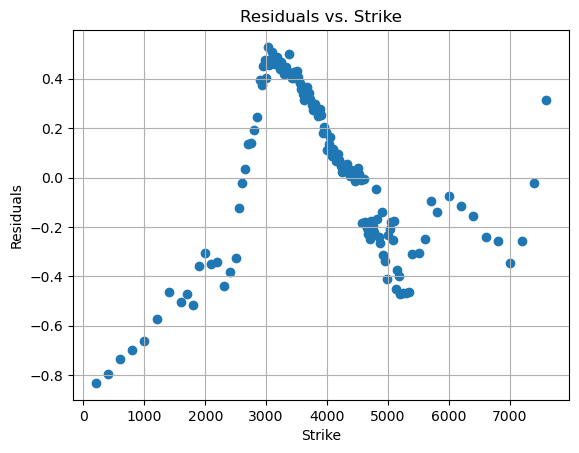

In [ ]:
residuals = results.resid

# Plot residuals versus the independent variable K
plt.scatter(dataNov15['Strike'], residuals)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Residuals vs. Strike')
plt.grid(True)
plt.show()

In [ ]:
r_imp = 1 - (-results.params[1])**(daysPerYear/daysToNov15)

div0_FT = S0*math.exp(r_imp*daysToNov15 / daysPerYear)
FT = results.params[0]/(-results.params[1])

# Calculate the implied dividend yield (y_imp)
y_imp = math.log(div0_FT / (FT)) * (daysPerYear / daysToNov15)


print(r_imp)
print(y_imp)


0.05003730701604159
0.010547544446488099


In [ ]:
dataNov15['IV Call'] = dataNov15.apply(lambda row: IV_Call(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row['Call Mid']), axis=1)
dataNov15['IV Put'] = dataNov15.apply(lambda row: IV_Put(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row['Put Mid']), axis=1)
dataNov15[['IV Call', 'IV Put']].fillna(0, inplace=True)


C:\Users\simon\AppData\Local\Temp\ipykernel_4148\1757302808.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  increment = (price - value) / vega
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\1757302808.py:2: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (math.log(S/K) + (r -y + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\1757302808.py:18: RuntimeWarning: invalid value encountered in scalar divide
  vega = S * math.exp(-y * T) * math.sqrt(T) * norm.pdf((math.log(S / K) + (r - y + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)))
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\1757302808.py:2: RuntimeWarning: overflow encountered in scalar power
  d1 = (math.log(S/K) + (r -y + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\1757302808.py:18: RuntimeWarning: overflow encountered in scalar power
  vega = S * math.exp(-y * T) * math.sqrt(T) * norm.p

Text(0.5, 1.0, 'Realized Variance vs. Strike')

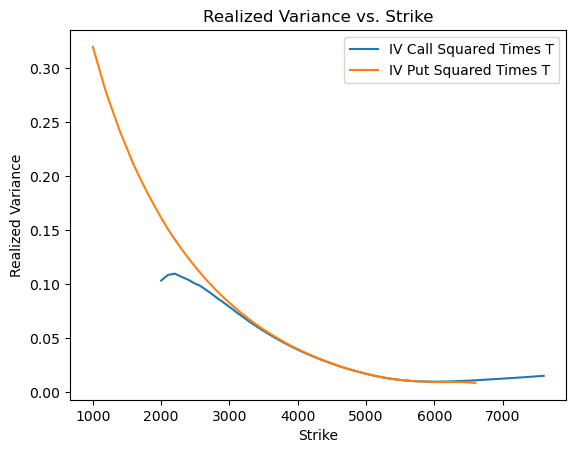

In [ ]:
Call_Variances = (dataNov15['IV Call'] ** 2) * T
Put_Variances = (dataNov15['IV Put'] ** 2) * T

plt.plot(dataNov15['Strike'], Call_Variances, label='IV Call Squared Times T')
plt.plot(dataNov15['Strike'], Put_Variances, label='IV Put Squared Times T')

# Set labels and title
plt.xlabel('Strike')
plt.ylabel('Realized Variance')
plt.legend()
plt.title('Realized Variance vs. Strike')

## Part C)

                            OLS Regression Results                            
Dep. Variable:                 Parity   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.546e+08
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          1.33e-179
Time:                        11:40:07   Log-Likelihood:                 39.844
No. Observations:                  52   AIC:                            -75.69
Df Residuals:                      50   BIC:                            -71.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4953.6353      0.181   2.74e+04      0.0

C:\Users\simon\AppData\Local\Temp\ipykernel_4148\4134987441.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restrictedNov15['IV Call'] = restrictedNov15.apply(lambda row: IV_Call(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row['Call Mid']), axis=1)
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\4134987441.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restrictedNov15['IV Put'] = restrictedNov15.apply(lambda row: IV_Put(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row[

Text(0.5, 1.0, 'Realized Variance vs. Strike')

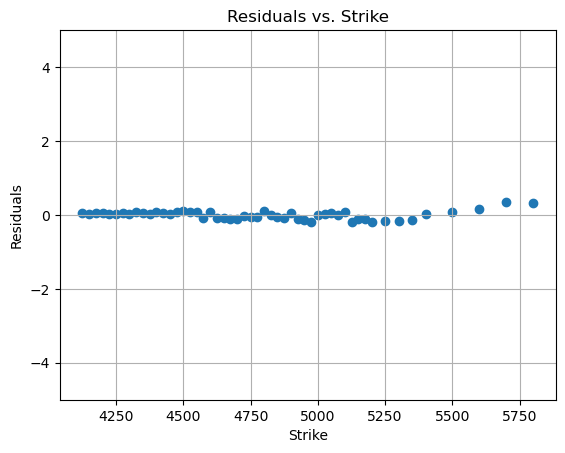

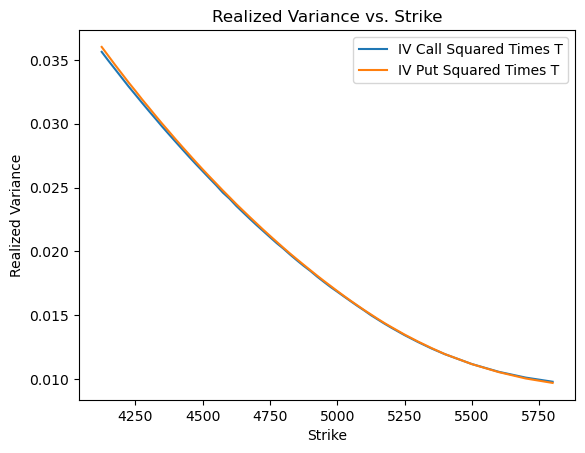

In [ ]:
restrictedNov15 = dataNov15[(dataNov15['Strike'] > 5000*(1-0.2*math.sqrt(daysToNov15/daysPerYear))) & (dataNov15['Strike'] < 5000*(1+0.2*math.sqrt(daysToNov15/daysPerYear)))]
restrictedNov15.head()
new_X = restrictedNov15['Strike']
new_y = restrictedNov15['Parity']
new_X = sm.add_constant(new_X)
new_results = sm.OLS(new_y, new_X).fit()
print(new_results.summary())

new_residuals = new_results.resid
plt.scatter(restrictedNov15['Strike'], new_residuals)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Residuals vs. Strike')
plt.ylim(-5, 5)
plt.grid(True)

FT = new_results.params[0]/(-new_results.params[1])
r_imp_new = 1 - (-new_results.params[1])**(daysPerYear/daysToNov15)

div0_FT_new = S0*math.exp(r_imp_new*daysToNov15 / daysPerYear)

# Calculate the implied dividend yield (y_imp)
y_imp_new = math.log(div0_FT_new / (FT)) * (daysPerYear / daysToNov15)

print(r_imp_new)
print(y_imp_new)

restrictedNov15['IV Call'] = restrictedNov15.apply(lambda row: IV_Call(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row['Call Mid']), axis=1)
restrictedNov15['IV Put'] = restrictedNov15.apply(lambda row: IV_Put(S0, row['Strike'], r_imp, y_imp, daysToNov15/daysPerYear, row['Put Mid']), axis=1)
restrictedNov15[['IV Call', 'IV Put']].fillna(0, inplace=True)

Call_Variances_new = (restrictedNov15['IV Call'] ** 2) * T
Put_Variances_new = (restrictedNov15['IV Put'] ** 2) * T

plt.figure()
plt.plot(restrictedNov15['Strike'], Call_Variances_new, label='IV Call Squared Times T')
plt.plot(restrictedNov15['Strike'], Put_Variances_new, label='IV Put Squared Times T')

# Set labels and title
plt.xlabel('Strike')
plt.ylabel('Realized Variance')
plt.legend()
plt.title('Realized Variance vs. Strike')

In [ ]:
#This just won't work

restrictedNov15['Call Spread'] = restrictedNov15['Ask'] - restrictedNov15['Bid']
restrictedNov15['Put Spread'] = restrictedNov15['Ask.1'] - restrictedNov15['Bid.1']

Y = restrictedNov15[['Call Mid', 'Put Mid']]
X = restrictedNov15['Strike']
X = sm.add_constant(X)
variances = restrictedNov15[['Call Spread', 'Put Spread']] ** 2
parity = new_results.params[0] + new_results.params[1] * restrictedNov15['Strike']

def loss_function(y_pred):
    return (y_pred[0] - Y[0])**2/variances[0] + (y_pred[1] - Y[1])**2/variances[1]

constraints = {'type': 'eq', 'fun': lambda params: parity - (params[0] - params[1])}
model = sm.GLM(Y, X)
result = model.fit_constrained(constraints, initial_guess=[np.zeros(X.shape[1]), np.zeros(X.shape[1])])
print(result.summary())


C:\Users\simon\AppData\Local\Temp\ipykernel_4148\2848513632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restrictedNov15['Call Spread'] = restrictedNov15['Ask'] - restrictedNov15['Bid']
C:\Users\simon\AppData\Local\Temp\ipykernel_4148\2848513632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restrictedNov15['Put Spread'] = restrictedNov15['Ask.1'] - restrictedNov15['Bid.1']


ValueError: unrecognized variable name/index 'type'